In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
# import glob
# import pickle
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib.pyplot import get_cmap

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir

# from analysis.density import kerneldensity
from sklearn.neighbors.kde import KernelDensity
from analysis.data_sample import data_randomize




# Load factor scores (positions in 5D-space)

In [2]:
# factor scores
path_read = os.path.join(src_dir,os.pardir,'data_filter')
fname_read = 'ipip300-no0_arr_pd_neoac_score-1.npy'
filename = os.path.join(path_read,fname_read)
arr_pd =  np.load(filename)

## z-score the data
N_,D_ = np.shape(arr_pd)
for d in range(D_):
    x_tmp = arr_pd[:,d]
    x_mu = np.mean(x_tmp)
    x_std = np.std(x_tmp)
    arr_pd[:,d] = (x_tmp - x_mu)/x_std
    
print(np.mean(arr_pd,axis=0),np.std(arr_pd,axis=0))

[ 3.04962354e-17 -2.69774390e-17  3.12781901e-18 -1.21202987e-17
  2.50225521e-17] [1. 1. 1. 1. 1.]


# Select 3 personality types

from Supplementary Table 1 (or directly from clustering)

In [3]:
x0 = np.array([-0.70, 0.52, 0.23, 0.62, 0.78]) ## Role Model type
x1 = np.array([-0.23, 0.70, -0.75, -0.56, -0.44]) ## Self-centered type
x2 = np.array([-0.54, -0.07, -0.77, 0.12, 0.19]) ## Reserved type

## Parameters for sampling of the hyperplane

The three vectors (x0, x1, x2) define a 2D-plane within the 5D-trait space.

We will sample the density in the 5D-space across this hyperplane.


In [4]:
n_s = 10 ## no. of points to sample in each of the 2 dimensions (n_s x n_s points in total)
## in the paper we used n_s = 100 to obtain a better resolution, 
## however this will take some time to calculate
smin=-2 ## minimum value to sample in each direction
smax=2 ## maximum value to sample in each direction
n_rep_kd2=100 ## number of realization to obtain density of randomized data
bw2 = 0.2 ## bandwidth for the kerneldensity

X = arr_pd ## the array to sample


## Construction of the hyperplane

We construct two orthonormal unit vectors e_s1 and e_s2 that span the hyperplane.

We then sample the plane along these unitvectors.



In [5]:

## the zero-vector is the origin
# x0 = np.zeros( len(x1) )
### thse two vectors span a 2D-hyperplane
v1 = x1-x0 ## this is the difference vector pointing from x0 to x1
v2 = x2-x0 ## this is the difference vector pointing from x0 to x2

## distance of x0 to the respective clusters
v_s1 = np.sqrt(np.sum(v1**2))
v_s2 = np.sqrt(np.sum(v2**2))


## get two orthonormal unit-vectors (gram-schmidt)
e_s1 = v1/v_s1
e_s2 = v2 - e_s1*np.sum( e_s1*v2 )
e_s2 = e_s2/np.sqrt(  np.sum(e_s2**2)  )

## We define xm, the average of x0,x1,x2; as the 0-origin of the plane
xm = x0 #np.zeros(5)# 1.0/3*(x0+x1+x2)

x0_es1,x0_es2 = np.sum((x0-xm)*e_s1), np.sum((x1-xm)*e_s2)
x1_es1,x1_es2 = np.sum((x1-xm)*e_s1), np.sum((x1-xm)*e_s2)
x2_es1,x2_es2 = np.sum((x2-xm)*e_s1), np.sum((x2-xm)*e_s2)

xm_es1 = 1.0/3*(x0_es1+x1_es1+x2_es1)
xm_es2 = 1.0/3*(x0_es2+x1_es2+x2_es2)

xm = xm+ xm_es1*e_s1 + xm_es2*e_s2

## project x0,x1,x2 into hyperplane in units of e_s1, e_s2
x0_es1,x0_es2 = np.sum((x0-xm)*e_s1), np.sum((x1-xm)*e_s2)
x1_es1,x1_es2 = np.sum((x1-xm)*e_s1), np.sum((x1-xm)*e_s2)
x2_es1,x2_es2 = np.sum((x2-xm)*e_s1), np.sum((x2-xm)*e_s2)


In [6]:
## Check whether the parametrization in the plane gives the correct coordinates
print(x0)
print(xm + x0_es1*e_s1 + x0_es2*e_s2)

print('')

print(x1)
print(xm + x1_es1*e_s1 + x1_es2*e_s2)

print('')

print(x2)
print(xm + x2_es1*e_s1 + x2_es2*e_s2)

[-0.7   0.52  0.23  0.62  0.78]
[-0.7   0.52  0.23  0.62  0.78]

[-0.23  0.7  -0.75 -0.56 -0.44]
[-0.23  0.7  -0.75 -0.56 -0.44]

[-0.54 -0.07 -0.77  0.12  0.19]
[-0.54 -0.07 -0.77  0.12  0.19]


In [7]:
## sample the density in the hyperplane

arr_s1 = np.linspace(smin,smax,n_s)
arr_s2 = np.linspace(smin,smax,n_s)

## fit the density estimator - original data
kde = KernelDensity(kernel='gaussian', bandwidth=bw2).fit(X)
arr_rho_s12 = np.zeros((len(arr_s1),len(arr_s2)))
for i_s1,s1 in enumerate(arr_s1):
    for i_s2,s2 in enumerate(arr_s2):
        x_tmp = xm + s1*e_s1 + s2*e_s2
        rho_tmp = kde.score_samples(x_tmp.reshape(1, -1))
        arr_rho_s12[i_s1,i_s2] = np.exp(rho_tmp)


arr_rho_s12_rand = np.zeros((n_rep_kd2,len(arr_s1),len(arr_s2)))
for i_nrep in range(n_rep_kd2):
    print('Random realization %s of %s'%(i_nrep,n_rep_kd2))
    ## fit the density estimator - randomomized data
    X_rand = data_randomize(X)#[:1000,:]
    kde_rand = KernelDensity(kernel='gaussian', bandwidth=bw2).fit(X_rand)

    for i_s1,s1 in enumerate(arr_s1):
        for i_s2,s2 in enumerate(arr_s2):
            x_tmp = xm + s1*e_s1 + s2*e_s2
            rho_tmp = kde_rand.score_samples(x_tmp.reshape(1, -1))
            arr_rho_s12_rand[i_nrep,i_s1,i_s2] = np.exp(rho_tmp)

    

Random realization 0 of 100
Random realization 1 of 100
Random realization 2 of 100
Random realization 3 of 100
Random realization 4 of 100
Random realization 5 of 100
Random realization 6 of 100
Random realization 7 of 100
Random realization 8 of 100
Random realization 9 of 100
Random realization 10 of 100
Random realization 11 of 100
Random realization 12 of 100
Random realization 13 of 100
Random realization 14 of 100
Random realization 15 of 100
Random realization 16 of 100
Random realization 17 of 100
Random realization 18 of 100
Random realization 19 of 100
Random realization 20 of 100
Random realization 21 of 100
Random realization 22 of 100
Random realization 23 of 100
Random realization 24 of 100
Random realization 25 of 100
Random realization 26 of 100
Random realization 27 of 100
Random realization 28 of 100
Random realization 29 of 100
Random realization 30 of 100
Random realization 31 of 100
Random realization 32 of 100
Random realization 33 of 100
Random realization 34 of

# Plot the result

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.0/1.4 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
Ampl = 1.0 # Amplification factor for screen: set this to ONE for final plot of eps
fig_size = [Ampl*fig_width,Ampl*fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.labelsize': Ampl*10,
          'text.fontsize': Ampl*8,
          'legend.fontsize': Ampl*8,
          'xtick.labelsize': Ampl*8,
          'ytick.labelsize': Ampl*8,
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          #'figtext.fontsize': Ampl*10,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          'xtick.direction':'out',
          'ytick.direction':'out'
         }
plt.rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  mplDeprecation)


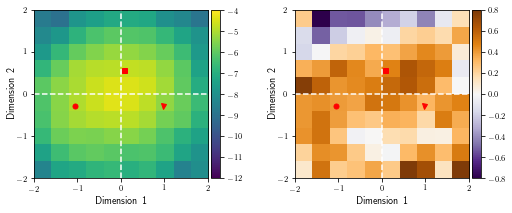

In [10]:
f = plt.figure(figsize=fig_size)

plt.clf()
#     plt.subplot(121)
xmin,xmax = arr_s1[0], arr_s1[-1]
ymin,ymax = arr_s2[0], arr_s2[-1]

extent = [xmin,xmax,ymin,ymax]
xlabel = r'Dimension 1'
ylabel = r'Dimension 2'
xticks = [-2,-1,0,1,2]
yticks = [-2,-1,0,1,2]

markers = ['o','v','s']

padx = 5
pady = 0
size_ms = 5
##############################
cmapname = 'viridis'

ax = f.add_subplot(121)
arr_z = (np.log(arr_rho_s12)).T
im = ax.imshow(arr_z, extent=extent, \
           origin='lower',aspect='auto',interpolation='nearest',vmin=-12,vmax=-4,cmap=get_cmap(cmapname))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')


ax.plot([x0_es1],[x0_es2],marker=markers[0],color='red',ms=size_ms)
ax.plot([x1_es1],[x1_es2],marker=markers[1],color='red',ms=size_ms)
ax.plot([x2_es1],[x2_es2],marker=markers[2],color='red',ms=size_ms)

ax.plot([xmin,xmax],[0,0],color='white',ls='--')
ax.plot([0,0],[ymin,ymax],color='white',ls='--')

ax.set_ylabel(ylabel,labelpad=pady)
ax.set_xlabel(xlabel,labelpad=padx)
ax.set_xticks(xticks)
ax.set_yticks(yticks)


# #############################\n",
# ### contours for projected sigma\n",
# ### this has to come from the gaussian mixture model,

# x = list_sigma_coords_x[0]
# y = list_sigma_coords_y[0]
# ax.plot(x,y,ls='-',lw=1,color='black')

# x = list_sigma_coords_x[1]
# y = list_sigma_coords_y[1]
# ax.plot(x,y,ls='-',lw=1,color='black')
# x = list_sigma_coords_x[2]
# y = list_sigma_coords_y[2]
# ax.plot(x,y,ls='-',lw=1,color='black')

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
##############################



ax = f.add_subplot(122)

cmapname = 'PuOr_r'
smax = 0.8
arr_z = (np.log(arr_rho_s12)-np.log(np.mean(arr_rho_s12_rand,axis=0))).T
im = ax.imshow(arr_z, \
           extent=extent, origin='lower',aspect='auto',interpolation='nearest',\
           vmin=-smax,vmax=smax,cmap=get_cmap(cmapname))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

# ax.plot([0.0],[0.0],marker='x',color='red',ms=10)
ax.plot([x0_es1],[x0_es2],marker=markers[0],color='red',ms=size_ms)
ax.plot([x1_es1],[x1_es2],marker=markers[1],color='red',ms=size_ms)
ax.plot([x2_es1],[x2_es2],marker=markers[2],color='red',ms=size_ms)

ax.plot([xmin,xmax],[0,0],color='white',ls='--')
ax.plot([0,0],[ymin,ymax],color='white',ls='--')
# ax.colorbar()


ax.set_ylabel(ylabel,labelpad=pady)
ax.set_xlabel(xlabel,labelpad=padx)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.subplots_adjust(left=0.1,bottom=0.2,wspace=0.4)
